In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LEAR

In [2]:
df = pd.read_csv("Data\EPFToolbox\BE.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [5]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2011-01-09 00:00:00,32.54,63065.0,63000.0,2011-01-09,0
1,2011-01-09 01:00:00,21.55,62715.0,58800.0,2011-01-09,1
2,2011-01-09 02:00:00,15.71,61952.0,58500.0,2011-01-09,2
3,2011-01-09 03:00:00,10.58,59262.0,54300.0,2011-01-09,3
4,2011-01-09 04:00:00,10.32,56883.0,51900.0,2011-01-09,4
...,...,...,...,...,...,...
52411,2016-12-31 19:00:00,40.84,70329.0,73957.0,2016-12-31,19
52412,2016-12-31 20:00:00,40.10,69121.0,72544.0,2016-12-31,20
52413,2016-12-31 21:00:00,36.00,66647.0,69451.0,2016-12-31,21
52414,2016-12-31 22:00:00,35.00,65886.0,67823.0,2016-12-31,22


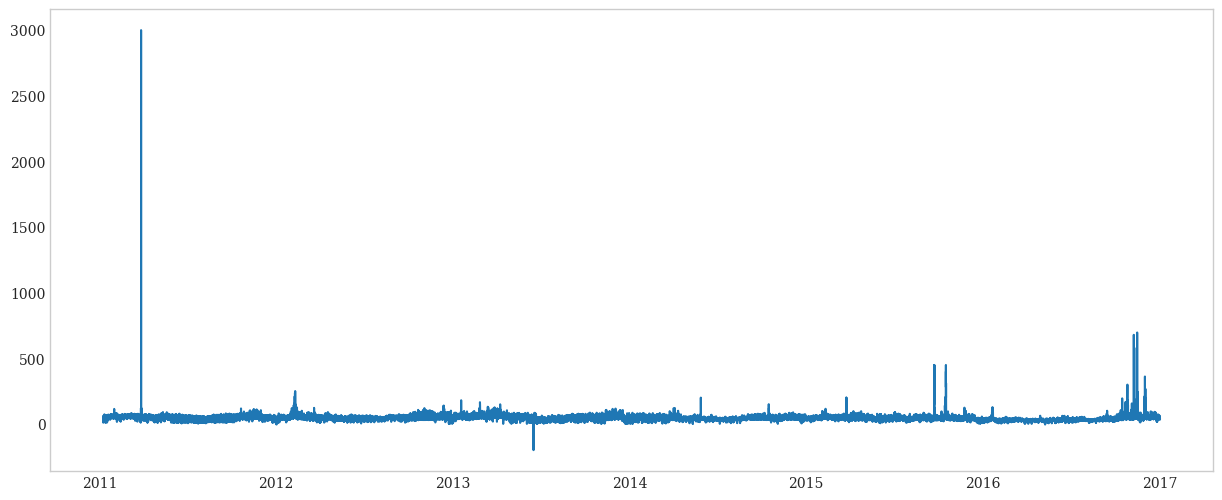

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [7]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [8]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [9]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

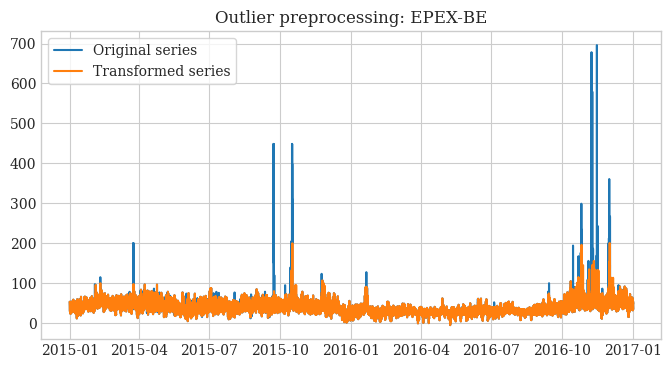

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(df[df.Date.dt.year >= 2015].Date, df[df.Date.dt.year >= 2015].Price, label='Original series')
ax.plot(df[df.Date.dt.year >= 2015].Date, df[df.Date.dt.year >= 2015].Price_no_outliers, label='Transformed series')
ax.legend(frameon=True)
ax.title.set_text('Outlier preprocessing: EPEX-BE')

In [15]:
fig.savefig('no_outlier_series.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
df = df[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [12]:
df.index = df.Date

In [13]:
df = df.drop(['Date'], axis = 1)

In [14]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [15]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [16]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [17]:
forecast_dates = forecast.index

In [18]:
from epftoolbox.models import LEAR

In [19]:
calibration_window = 2*364

In [20]:
model = LEAR(calibration_window=calibration_window)

In [21]:
df_original = pd.read_csv(r"Data\EPFToolbox\BE.csv")

In [22]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [23]:
df_original.index = df_original.Date

In [24]:
df_original = df_original.drop('Date', axis = 1)

In [25]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [26]:
df_original = df_original[df_original.index >= dt.datetime(2015, 1, 1)]

In [27]:
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [28]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,33.29,32.47,34.73,40.95,51.25,52.55,49.55,46.31,48.75,47.59
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,41.00,39.78,39.73,50.24,54.10,53.13,48.81,42.99,48.76,48.45
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,42.44,39.94,42.44,53.10,49.82,47.62,43.79,42.44,42.03,40.91
2015-01-04,36.26,32.28,27.63,27.03,27.04,27.19,27.13,27.06,27.63,34.54,...,37.00,36.87,40.00,53.10,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-05,36.56,34.94,32.19,28.05,28.04,34.26,44.28,50.38,53.79,52.03,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,35.30,38.33,41.04,34.62,29.69,28.35,30.99,42.08,45.27,46.56,...,51.27,51.82,65.19,69.99,72.89,72.15,52.07,44.00,56.41,63.25
2016-12-28,37.12,36.03,34.15,36.03,33.95,34.82,43.70,51.00,53.00,57.34,...,50.77,51.60,55.20,63.29,63.70,59.82,61.20,50.00,43.18,43.77
2016-12-29,42.28,39.30,36.83,34.11,34.99,37.64,41.05,49.30,53.30,53.93,...,49.60,51.63,54.43,63.95,64.35,56.72,48.50,45.66,46.94,44.08


In [30]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 17.10%  |  MAE: 7.009
2015-01-02 - sMAPE: 13.98%  |  MAE: 5.522
2015-01-03 - sMAPE: 12.32%  |  MAE: 4.965
2015-01-04 - sMAPE: 11.84%  |  MAE: 4.694
2015-01-05 - sMAPE: 10.63%  |  MAE: 4.298
2015-01-06 - sMAPE: 10.44%  |  MAE: 4.325
2015-01-07 - sMAPE: 9.68%  |  MAE: 4.057
2015-01-08 - sMAPE: 9.16%  |  MAE: 3.851
2015-01-09 - sMAPE: 9.87%  |  MAE: 4.107
2015-01-10 - sMAPE: 10.24%  |  MAE: 4.176
2015-01-11 - sMAPE: 10.60%  |  MAE: 4.204
2015-01-12 - sMAPE: 10.45%  |  MAE: 4.136
2015-01-13 - sMAPE: 10.35%  |  MAE: 4.113
2015-01-14 - sMAPE: 10.10%  |  MAE: 4.020
2015-01-15 - sMAPE: 10.26%  |  MAE: 4.099
2015-01-16 - sMAPE: 9.92%  |  MAE: 3.956
2015-01-17 - sMAPE: 9.88%  |  MAE: 3.937
2015-01-18 - sMAPE: 9.79%  |  MAE: 3.886
2015-01-19 - sMAPE: 9.57%  |  MAE: 3.815
2015-01-20 - sMAPE: 9.36%  |  MAE: 3.746
2015-01-21 - sMAPE: 9.31%  |  MAE: 3.746
2015-01-22 - sMAPE: 9.17%  |  MAE: 3.714
2015-01-23 - sMAPE: 9.02%  |  MAE: 3.675
2015-01-24 - sMAPE: 9.02%  |  MAE: 3.687
2015

2015-07-17 - sMAPE: 14.71%  |  MAE: 6.381
2015-07-18 - sMAPE: 14.68%  |  MAE: 6.368
2015-07-19 - sMAPE: 14.69%  |  MAE: 6.364
2015-07-20 - sMAPE: 14.67%  |  MAE: 6.356
2015-07-21 - sMAPE: 14.63%  |  MAE: 6.346
2015-07-22 - sMAPE: 14.58%  |  MAE: 6.325
2015-07-23 - sMAPE: 14.54%  |  MAE: 6.308
2015-07-24 - sMAPE: 14.50%  |  MAE: 6.292
2015-07-25 - sMAPE: 14.63%  |  MAE: 6.323
2015-07-26 - sMAPE: 14.67%  |  MAE: 6.321
2015-07-27 - sMAPE: 14.71%  |  MAE: 6.326
2015-07-28 - sMAPE: 14.80%  |  MAE: 6.349
2015-07-29 - sMAPE: 14.83%  |  MAE: 6.351
2015-07-30 - sMAPE: 14.84%  |  MAE: 6.350
2015-07-31 - sMAPE: 14.84%  |  MAE: 6.346
2015-08-01 - sMAPE: 14.87%  |  MAE: 6.349
2015-08-02 - sMAPE: 14.93%  |  MAE: 6.361
2015-08-03 - sMAPE: 14.93%  |  MAE: 6.360
2015-08-04 - sMAPE: 14.93%  |  MAE: 6.356
2015-08-05 - sMAPE: 14.91%  |  MAE: 6.345
2015-08-06 - sMAPE: 14.88%  |  MAE: 6.331
2015-08-07 - sMAPE: 14.84%  |  MAE: 6.312
2015-08-08 - sMAPE: 14.86%  |  MAE: 6.311
2015-08-09 - sMAPE: 14.84%  |  MAE

2016-01-29 - sMAPE: 15.55%  |  MAE: 7.125
2016-01-30 - sMAPE: 15.57%  |  MAE: 7.122
2016-01-31 - sMAPE: 15.69%  |  MAE: 7.124
2016-02-01 - sMAPE: 15.69%  |  MAE: 7.116
2016-02-02 - sMAPE: 15.73%  |  MAE: 7.114
2016-02-03 - sMAPE: 15.75%  |  MAE: 7.111
2016-02-04 - sMAPE: 15.75%  |  MAE: 7.106
2016-02-05 - sMAPE: 15.74%  |  MAE: 7.096
2016-02-06 - sMAPE: 15.77%  |  MAE: 7.093
2016-02-07 - sMAPE: 15.91%  |  MAE: 7.095
2016-02-08 - sMAPE: 15.94%  |  MAE: 7.091
2016-02-09 - sMAPE: 15.95%  |  MAE: 7.085
2016-02-10 - sMAPE: 15.94%  |  MAE: 7.077
2016-02-11 - sMAPE: 15.92%  |  MAE: 7.065
2016-02-12 - sMAPE: 15.91%  |  MAE: 7.058
2016-02-13 - sMAPE: 15.91%  |  MAE: 7.050
2016-02-14 - sMAPE: 15.95%  |  MAE: 7.045
2016-02-15 - sMAPE: 15.94%  |  MAE: 7.036
2016-02-16 - sMAPE: 15.92%  |  MAE: 7.027
2016-02-17 - sMAPE: 15.90%  |  MAE: 7.018
2016-02-18 - sMAPE: 15.88%  |  MAE: 7.006
2016-02-19 - sMAPE: 15.88%  |  MAE: 7.002
2016-02-20 - sMAPE: 15.92%  |  MAE: 7.003
2016-02-21 - sMAPE: 16.12%  |  MAE

2016-08-12 - sMAPE: 15.63%  |  MAE: 5.963
2016-08-13 - sMAPE: 15.64%  |  MAE: 5.960
2016-08-14 - sMAPE: 15.63%  |  MAE: 5.954
2016-08-15 - sMAPE: 15.62%  |  MAE: 5.948
2016-08-16 - sMAPE: 15.61%  |  MAE: 5.942
2016-08-17 - sMAPE: 15.60%  |  MAE: 5.937
2016-08-18 - sMAPE: 15.58%  |  MAE: 5.930
2016-08-19 - sMAPE: 15.57%  |  MAE: 5.923
2016-08-20 - sMAPE: 15.56%  |  MAE: 5.918
2016-08-21 - sMAPE: 15.60%  |  MAE: 5.919
2016-08-22 - sMAPE: 15.59%  |  MAE: 5.914
2016-08-23 - sMAPE: 15.57%  |  MAE: 5.907
2016-08-24 - sMAPE: 15.56%  |  MAE: 5.901
2016-08-25 - sMAPE: 15.55%  |  MAE: 5.896
2016-08-26 - sMAPE: 15.53%  |  MAE: 5.890
2016-08-27 - sMAPE: 15.52%  |  MAE: 5.886
2016-08-28 - sMAPE: 15.52%  |  MAE: 5.880
2016-08-29 - sMAPE: 15.53%  |  MAE: 5.884
2016-08-30 - sMAPE: 15.53%  |  MAE: 5.884
2016-08-31 - sMAPE: 15.53%  |  MAE: 5.881
2016-09-01 - sMAPE: 15.52%  |  MAE: 5.876
2016-09-02 - sMAPE: 15.52%  |  MAE: 5.876
2016-09-03 - sMAPE: 15.52%  |  MAE: 5.873
2016-09-04 - sMAPE: 15.51%  |  MAE

In [31]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.621769,39.229606,37.174769,33.583551,31.736821,32.239794,34.998413,41.332393,43.260835,47.038003,...,42.883152,39.43583,40.743515,51.92984,57.102243,54.135147,49.843352,45.256636,48.174053,45.8637
2015-01-02,43.060974,39.774432,38.848871,35.509861,33.996082,34.201034,37.537422,41.969221,43.728716,48.627038,...,43.9078,41.166608,40.228308,49.946706,56.019182,55.708496,51.093759,47.494821,49.353022,47.538094
2015-01-03,40.453105,36.247649,34.287107,30.422886,30.050544,30.409231,33.505715,39.654524,43.066912,49.269768,...,44.636792,41.207643,40.653342,50.696011,58.317278,53.151999,47.570274,44.094482,47.808423,45.145022
2015-01-04,38.399705,35.037729,34.042587,32.132231,30.730657,29.449607,28.430604,29.022658,37.385553,38.473965,...,42.648872,39.486256,41.613118,50.085868,58.201563,53.415295,49.577338,45.499229,47.021299,44.365842
2015-01-05,36.112775,34.085401,32.13381,29.397319,29.20611,31.059369,40.380009,48.768925,50.273757,53.228855,...,47.371195,47.391504,49.653801,60.743042,64.733025,57.67182,52.251767,46.149886,48.244973,45.124328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,37.04149,32.538091,30.465887,26.903817,24.553754,28.200278,38.785866,47.789452,52.058368,53.218457,...,50.097786,48.222337,49.279357,61.644032,61.999876,58.986511,51.291813,44.472471,45.084368,45.865394
2016-12-28,43.079296,38.422252,37.004787,31.682307,30.066445,33.278731,42.992744,51.239853,54.333125,55.893942,...,50.13266,51.093976,55.034133,62.731133,64.247875,64.11347,52.36728,46.300024,48.597559,49.481712
2016-12-29,39.784778,35.720135,34.322136,32.071645,30.953304,34.550228,45.091111,56.202179,59.742955,59.929073,...,55.932269,55.834324,58.214903,68.610376,72.220682,66.223112,59.756894,48.086957,47.455375,47.22705


In [32]:
forecast.to_csv("Resultados/be_epftoolbox_final_2_anos_ventana_no_outliers.csv")

In [33]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [34]:
forecast_dates = forecast.index

In [35]:
calibration_window = 1*364

In [36]:
model = LEAR(calibration_window=calibration_window)

In [37]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 19.11%  |  MAE: 7.811
2015-01-02 - sMAPE: 14.38%  |  MAE: 5.708
2015-01-03 - sMAPE: 12.27%  |  MAE: 4.914
2015-01-04 - sMAPE: 12.42%  |  MAE: 4.875
2015-01-05 - sMAPE: 10.86%  |  MAE: 4.305
2015-01-06 - sMAPE: 10.56%  |  MAE: 4.254
2015-01-07 - sMAPE: 9.80%  |  MAE: 3.991
2015-01-08 - sMAPE: 9.19%  |  MAE: 3.752
2015-01-09 - sMAPE: 9.69%  |  MAE: 3.927
2015-01-10 - sMAPE: 10.22%  |  MAE: 4.048
2015-01-11 - sMAPE: 10.93%  |  MAE: 4.239
2015-01-12 - sMAPE: 10.69%  |  MAE: 4.127
2015-01-13 - sMAPE: 10.58%  |  MAE: 4.112
2015-01-14 - sMAPE: 10.24%  |  MAE: 3.996
2015-01-15 - sMAPE: 10.45%  |  MAE: 4.094
2015-01-16 - sMAPE: 10.16%  |  MAE: 3.985
2015-01-17 - sMAPE: 10.11%  |  MAE: 3.964
2015-01-18 - sMAPE: 9.93%  |  MAE: 3.893
2015-01-19 - sMAPE: 9.86%  |  MAE: 3.891
2015-01-20 - sMAPE: 9.77%  |  MAE: 3.882
2015-01-21 - sMAPE: 9.78%  |  MAE: 3.913
2015-01-22 - sMAPE: 9.75%  |  MAE: 3.933
2015-01-23 - sMAPE: 9.55%  |  MAE: 3.873
2015-01-24 - sMAPE: 9.54%  |  MAE: 3.869
20

2015-07-17 - sMAPE: 15.26%  |  MAE: 6.589
2015-07-18 - sMAPE: 15.23%  |  MAE: 6.578
2015-07-19 - sMAPE: 15.25%  |  MAE: 6.578
2015-07-20 - sMAPE: 15.24%  |  MAE: 6.573
2015-07-21 - sMAPE: 15.21%  |  MAE: 6.567
2015-07-22 - sMAPE: 15.16%  |  MAE: 6.544
2015-07-23 - sMAPE: 15.11%  |  MAE: 6.527
2015-07-24 - sMAPE: 15.07%  |  MAE: 6.509
2015-07-25 - sMAPE: 15.20%  |  MAE: 6.542
2015-07-26 - sMAPE: 15.25%  |  MAE: 6.543
2015-07-27 - sMAPE: 15.29%  |  MAE: 6.548
2015-07-28 - sMAPE: 15.39%  |  MAE: 6.573
2015-07-29 - sMAPE: 15.44%  |  MAE: 6.584
2015-07-30 - sMAPE: 15.46%  |  MAE: 6.586
2015-07-31 - sMAPE: 15.46%  |  MAE: 6.584
2015-08-01 - sMAPE: 15.51%  |  MAE: 6.593
2015-08-02 - sMAPE: 15.57%  |  MAE: 6.605
2015-08-03 - sMAPE: 15.57%  |  MAE: 6.601
2015-08-04 - sMAPE: 15.56%  |  MAE: 6.595
2015-08-05 - sMAPE: 15.53%  |  MAE: 6.583
2015-08-06 - sMAPE: 15.50%  |  MAE: 6.567
2015-08-07 - sMAPE: 15.46%  |  MAE: 6.548
2015-08-08 - sMAPE: 15.48%  |  MAE: 6.552
2015-08-09 - sMAPE: 15.47%  |  MAE

2016-01-29 - sMAPE: 16.23%  |  MAE: 7.366
2016-01-30 - sMAPE: 16.25%  |  MAE: 7.363
2016-01-31 - sMAPE: 16.32%  |  MAE: 7.361
2016-02-01 - sMAPE: 16.33%  |  MAE: 7.353
2016-02-02 - sMAPE: 16.37%  |  MAE: 7.351
2016-02-03 - sMAPE: 16.39%  |  MAE: 7.349
2016-02-04 - sMAPE: 16.39%  |  MAE: 7.343
2016-02-05 - sMAPE: 16.38%  |  MAE: 7.334
2016-02-06 - sMAPE: 16.41%  |  MAE: 7.330
2016-02-07 - sMAPE: 16.46%  |  MAE: 7.324
2016-02-08 - sMAPE: 16.49%  |  MAE: 7.320
2016-02-09 - sMAPE: 16.49%  |  MAE: 7.314
2016-02-10 - sMAPE: 16.48%  |  MAE: 7.305
2016-02-11 - sMAPE: 16.46%  |  MAE: 7.292
2016-02-12 - sMAPE: 16.45%  |  MAE: 7.285
2016-02-13 - sMAPE: 16.45%  |  MAE: 7.276
2016-02-14 - sMAPE: 16.48%  |  MAE: 7.270
2016-02-15 - sMAPE: 16.47%  |  MAE: 7.261
2016-02-16 - sMAPE: 16.46%  |  MAE: 7.252
2016-02-17 - sMAPE: 16.45%  |  MAE: 7.243
2016-02-18 - sMAPE: 16.42%  |  MAE: 7.231
2016-02-19 - sMAPE: 16.42%  |  MAE: 7.226
2016-02-20 - sMAPE: 16.46%  |  MAE: 7.227
2016-02-21 - sMAPE: 16.62%  |  MAE

2016-08-12 - sMAPE: 15.93%  |  MAE: 6.142
2016-08-13 - sMAPE: 15.93%  |  MAE: 6.138
2016-08-14 - sMAPE: 15.92%  |  MAE: 6.131
2016-08-15 - sMAPE: 15.91%  |  MAE: 6.124
2016-08-16 - sMAPE: 15.89%  |  MAE: 6.117
2016-08-17 - sMAPE: 15.88%  |  MAE: 6.112
2016-08-18 - sMAPE: 15.87%  |  MAE: 6.105
2016-08-19 - sMAPE: 15.86%  |  MAE: 6.099
2016-08-20 - sMAPE: 15.85%  |  MAE: 6.094
2016-08-21 - sMAPE: 15.90%  |  MAE: 6.096
2016-08-22 - sMAPE: 15.89%  |  MAE: 6.091
2016-08-23 - sMAPE: 15.88%  |  MAE: 6.086
2016-08-24 - sMAPE: 15.86%  |  MAE: 6.080
2016-08-25 - sMAPE: 15.85%  |  MAE: 6.075
2016-08-26 - sMAPE: 15.83%  |  MAE: 6.069
2016-08-27 - sMAPE: 15.83%  |  MAE: 6.064
2016-08-28 - sMAPE: 15.82%  |  MAE: 6.058
2016-08-29 - sMAPE: 15.83%  |  MAE: 6.063
2016-08-30 - sMAPE: 15.84%  |  MAE: 6.063
2016-08-31 - sMAPE: 15.84%  |  MAE: 6.061
2016-09-01 - sMAPE: 15.82%  |  MAE: 6.056
2016-09-02 - sMAPE: 15.83%  |  MAE: 6.056
2016-09-03 - sMAPE: 15.82%  |  MAE: 6.051
2016-09-04 - sMAPE: 15.82%  |  MAE

In [38]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,42.469257,37.308628,35.702929,31.876365,30.296562,31.63959,35.253978,42.893575,45.904328,50.412721,...,42.647095,40.189868,41.245276,52.824484,56.017974,52.838081,48.643426,43.986484,45.937977,42.458766
2015-01-02,41.979648,36.732334,36.148696,32.652389,32.254654,32.601529,37.274211,45.822352,47.503559,50.020782,...,43.426429,40.264019,41.465487,50.718811,57.209354,54.999708,49.475791,44.492282,46.885934,43.159726
2015-01-03,39.758871,35.913643,33.49112,29.793857,28.020229,29.667118,34.863269,42.873868,45.114001,50.039184,...,42.342138,40.66759,43.058821,50.667396,57.530204,52.053035,47.328794,42.613478,45.057126,42.506408
2015-01-04,37.300529,33.637917,34.197309,31.895583,30.196435,30.41621,34.916663,33.459097,42.072092,43.864201,...,41.841691,39.586811,43.008955,52.523503,56.544755,53.108745,49.439185,44.489474,46.276867,42.410845
2015-01-05,36.129406,33.310189,30.876607,28.582998,28.087574,29.983215,38.353461,48.866508,50.5366,51.867231,...,45.976391,43.898725,46.645118,57.085419,59.761265,57.943063,50.423265,43.18724,45.536388,42.702688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,36.239652,29.564956,28.224386,25.027456,24.474422,28.589005,39.327405,48.373154,53.500662,53.428524,...,50.406425,49.468446,49.786854,63.888585,61.998392,56.652306,49.985363,42.093462,43.614346,42.92061
2016-12-28,39.912905,34.252042,33.557317,31.46585,30.26228,33.102688,40.797124,49.012439,55.208293,57.249702,...,52.68176,52.722787,55.476192,64.900203,61.811475,63.528675,53.785315,43.512578,46.15753,45.739661
2016-12-29,38.428127,34.731452,33.024435,31.053564,30.105206,34.562091,42.460839,57.125463,61.82423,57.555012,...,55.21984,56.089709,56.683838,70.707973,73.084831,67.293964,56.190984,47.050156,46.118124,48.097376


In [39]:
forecast.to_csv("Resultados/be_epftoolbox_final_1_anos_ventana_no_outliers.csv")

In [29]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [30]:
forecast_dates = forecast.index

In [31]:
calibration_window = 182

In [32]:
model = LEAR(calibration_window=calibration_window)

In [33]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 18.69%  |  MAE: 7.871
2015-01-02 - sMAPE: 15.71%  |  MAE: 6.422
2015-01-03 - sMAPE: 13.20%  |  MAE: 5.385
2015-01-04 - sMAPE: 12.82%  |  MAE: 5.125
2015-01-05 - sMAPE: 11.52%  |  MAE: 4.660
2015-01-06 - sMAPE: 10.97%  |  MAE: 4.504
2015-01-07 - sMAPE: 10.13%  |  MAE: 4.204
2015-01-08 - sMAPE: 9.69%  |  MAE: 4.024
2015-01-09 - sMAPE: 10.41%  |  MAE: 4.270
2015-01-10 - sMAPE: 10.82%  |  MAE: 4.348
2015-01-11 - sMAPE: 11.61%  |  MAE: 4.537
2015-01-12 - sMAPE: 11.48%  |  MAE: 4.478
2015-01-13 - sMAPE: 11.27%  |  MAE: 4.408
2015-01-14 - sMAPE: 10.99%  |  MAE: 4.325
2015-01-15 - sMAPE: 11.09%  |  MAE: 4.370
2015-01-16 - sMAPE: 10.78%  |  MAE: 4.252
2015-01-17 - sMAPE: 10.77%  |  MAE: 4.264
2015-01-18 - sMAPE: 10.46%  |  MAE: 4.138
2015-01-19 - sMAPE: 10.26%  |  MAE: 4.086
2015-01-20 - sMAPE: 10.10%  |  MAE: 4.047
2015-01-21 - sMAPE: 10.08%  |  MAE: 4.071
2015-01-22 - sMAPE: 9.98%  |  MAE: 4.060
2015-01-23 - sMAPE: 9.81%  |  MAE: 4.016
2015-01-24 - sMAPE: 9.81%  |  MAE: 4.

2015-07-17 - sMAPE: 16.32%  |  MAE: 7.041
2015-07-18 - sMAPE: 16.29%  |  MAE: 7.027
2015-07-19 - sMAPE: 16.31%  |  MAE: 7.028
2015-07-20 - sMAPE: 16.28%  |  MAE: 7.017
2015-07-21 - sMAPE: 16.25%  |  MAE: 7.008
2015-07-22 - sMAPE: 16.20%  |  MAE: 6.985
2015-07-23 - sMAPE: 16.15%  |  MAE: 6.969
2015-07-24 - sMAPE: 16.11%  |  MAE: 6.949
2015-07-25 - sMAPE: 16.22%  |  MAE: 6.974
2015-07-26 - sMAPE: 16.26%  |  MAE: 6.972
2015-07-27 - sMAPE: 16.29%  |  MAE: 6.974
2015-07-28 - sMAPE: 16.40%  |  MAE: 7.000
2015-07-29 - sMAPE: 16.43%  |  MAE: 7.004
2015-07-30 - sMAPE: 16.45%  |  MAE: 7.006
2015-07-31 - sMAPE: 16.43%  |  MAE: 6.996
2015-08-01 - sMAPE: 16.48%  |  MAE: 7.006
2015-08-02 - sMAPE: 16.56%  |  MAE: 7.024
2015-08-03 - sMAPE: 16.55%  |  MAE: 7.016
2015-08-04 - sMAPE: 16.55%  |  MAE: 7.011
2015-08-05 - sMAPE: 16.51%  |  MAE: 6.996
2015-08-06 - sMAPE: 16.47%  |  MAE: 6.978
2015-08-07 - sMAPE: 16.42%  |  MAE: 6.956
2015-08-08 - sMAPE: 16.43%  |  MAE: 6.952
2015-08-09 - sMAPE: 16.42%  |  MAE

2016-01-29 - sMAPE: 17.04%  |  MAE: 7.702
2016-01-30 - sMAPE: 17.07%  |  MAE: 7.702
2016-01-31 - sMAPE: 17.12%  |  MAE: 7.699
2016-02-01 - sMAPE: 17.12%  |  MAE: 7.688
2016-02-02 - sMAPE: 17.14%  |  MAE: 7.683
2016-02-03 - sMAPE: 17.15%  |  MAE: 7.675
2016-02-04 - sMAPE: 17.14%  |  MAE: 7.666
2016-02-05 - sMAPE: 17.13%  |  MAE: 7.657
2016-02-06 - sMAPE: 17.17%  |  MAE: 7.656
2016-02-07 - sMAPE: 17.23%  |  MAE: 7.649
2016-02-08 - sMAPE: 17.23%  |  MAE: 7.637
2016-02-09 - sMAPE: 17.22%  |  MAE: 7.626
2016-02-10 - sMAPE: 17.20%  |  MAE: 7.614
2016-02-11 - sMAPE: 17.18%  |  MAE: 7.601
2016-02-12 - sMAPE: 17.17%  |  MAE: 7.593
2016-02-13 - sMAPE: 17.17%  |  MAE: 7.584
2016-02-14 - sMAPE: 17.19%  |  MAE: 7.576
2016-02-15 - sMAPE: 17.17%  |  MAE: 7.564
2016-02-16 - sMAPE: 17.16%  |  MAE: 7.555
2016-02-17 - sMAPE: 17.15%  |  MAE: 7.547
2016-02-18 - sMAPE: 17.12%  |  MAE: 7.534
2016-02-19 - sMAPE: 17.12%  |  MAE: 7.530
2016-02-20 - sMAPE: 17.15%  |  MAE: 7.527
2016-02-21 - sMAPE: 17.27%  |  MAE

2016-08-12 - sMAPE: 16.35%  |  MAE: 6.356
2016-08-13 - sMAPE: 16.35%  |  MAE: 6.351
2016-08-14 - sMAPE: 16.34%  |  MAE: 6.344
2016-08-15 - sMAPE: 16.33%  |  MAE: 6.337
2016-08-16 - sMAPE: 16.31%  |  MAE: 6.329
2016-08-17 - sMAPE: 16.30%  |  MAE: 6.324
2016-08-18 - sMAPE: 16.29%  |  MAE: 6.319
2016-08-19 - sMAPE: 16.28%  |  MAE: 6.314
2016-08-20 - sMAPE: 16.27%  |  MAE: 6.306
2016-08-21 - sMAPE: 16.32%  |  MAE: 6.308
2016-08-22 - sMAPE: 16.31%  |  MAE: 6.302
2016-08-23 - sMAPE: 16.30%  |  MAE: 6.297
2016-08-24 - sMAPE: 16.28%  |  MAE: 6.291
2016-08-25 - sMAPE: 16.27%  |  MAE: 6.286
2016-08-26 - sMAPE: 16.26%  |  MAE: 6.281
2016-08-27 - sMAPE: 16.25%  |  MAE: 6.275
2016-08-28 - sMAPE: 16.24%  |  MAE: 6.269
2016-08-29 - sMAPE: 16.25%  |  MAE: 6.272
2016-08-30 - sMAPE: 16.25%  |  MAE: 6.272
2016-08-31 - sMAPE: 16.25%  |  MAE: 6.270
2016-09-01 - sMAPE: 16.24%  |  MAE: 6.264
2016-09-02 - sMAPE: 16.24%  |  MAE: 6.263
2016-09-03 - sMAPE: 16.23%  |  MAE: 6.257
2016-09-04 - sMAPE: 16.22%  |  MAE

In [34]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,44.133924,39.855038,36.890715,33.460754,32.4485,33.219775,34.847745,37.248669,41.49967,49.801278,...,44.538632,42.267924,45.06385,60.885516,56.110777,52.588841,50.190378,44.959776,47.74367,45.198255
2015-01-02,43.778737,39.777141,37.320415,34.791307,33.840526,33.614917,36.985266,41.834367,42.686105,47.673741,...,48.590495,45.745544,47.692038,57.706135,56.668715,55.213561,49.217051,46.566705,48.741388,46.152408
2015-01-03,41.711301,36.813597,33.396607,30.572634,29.018564,30.367456,29.827819,37.751155,39.799787,47.624184,...,43.279222,41.807844,43.869697,54.198048,55.005569,48.287816,46.098576,42.797608,45.886538,42.621698
2015-01-04,38.944907,35.190199,34.00379,32.33275,31.245152,30.120119,30.031813,32.604501,31.525083,42.314744,...,42.62127,41.146856,43.994243,55.113998,54.605549,51.709568,47.657214,43.817065,47.167221,43.682545
2015-01-05,37.757265,33.829653,31.416748,29.796887,30.204154,30.262559,39.402437,46.570103,48.208867,50.004198,...,48.732962,47.312555,49.782895,61.00514,58.525041,55.100599,50.663404,44.937687,46.417425,44.643336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,32.330087,30.402666,30.843452,27.657088,23.447391,28.116209,37.378069,48.16489,57.026232,52.629078,...,52.84629,51.490741,55.661943,66.218357,58.511694,58.352245,50.965118,44.726328,44.888089,43.770221
2016-12-28,38.486001,36.789966,36.025801,34.928847,30.84804,35.283647,41.953473,48.916279,49.497653,55.073948,...,56.478714,53.99262,64.277767,61.097518,58.729736,64.472234,55.033896,48.7547,50.000198,52.14218
2016-12-29,36.589543,35.881326,35.319901,34.303928,31.062678,35.790449,42.001195,55.178951,59.706338,55.914018,...,59.436086,61.443604,64.813005,74.773393,77.075702,69.327386,60.220081,47.666817,48.330581,47.653693


In [35]:
forecast.to_csv("Resultados/be_epftoolbox_final_6_meses_ventana_no_outliers.csv")

# Estandarización móvil + LEAR + No outliers

In [2]:
df = pd.read_csv("Data\EPFToolbox\BE.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [5]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2011-01-09 00:00:00,32.54,63065.0,63000.0,2011-01-09,0
1,2011-01-09 01:00:00,21.55,62715.0,58800.0,2011-01-09,1
2,2011-01-09 02:00:00,15.71,61952.0,58500.0,2011-01-09,2
3,2011-01-09 03:00:00,10.58,59262.0,54300.0,2011-01-09,3
4,2011-01-09 04:00:00,10.32,56883.0,51900.0,2011-01-09,4
...,...,...,...,...,...,...
52411,2016-12-31 19:00:00,40.84,70329.0,73957.0,2016-12-31,19
52412,2016-12-31 20:00:00,40.10,69121.0,72544.0,2016-12-31,20
52413,2016-12-31 21:00:00,36.00,66647.0,69451.0,2016-12-31,21
52414,2016-12-31 22:00:00,35.00,65886.0,67823.0,2016-12-31,22


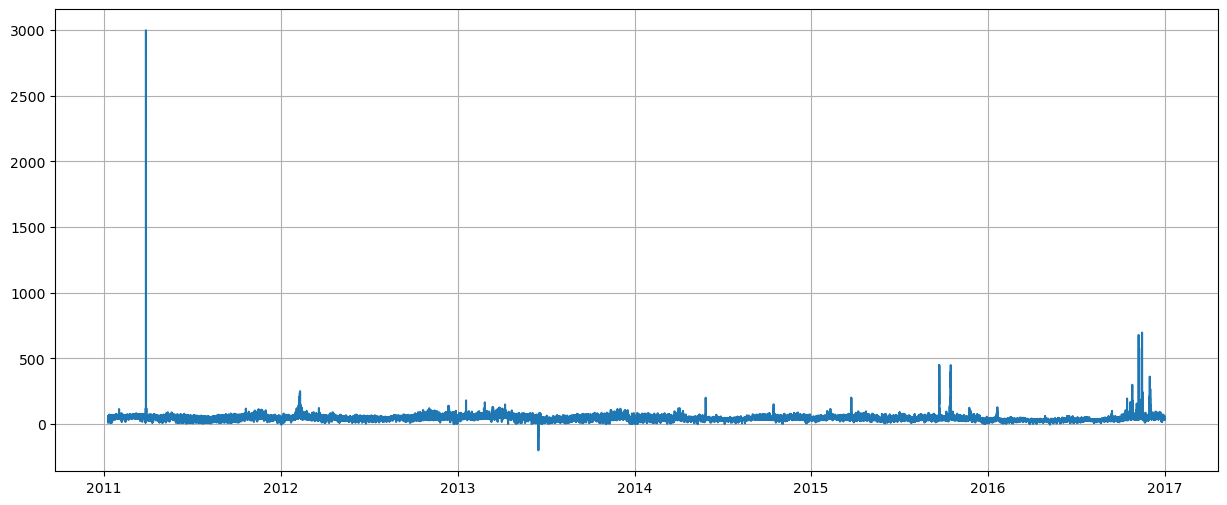

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

Se añaden variables auxiliares

In [7]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [8]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

In [9]:
df.outlier.sum()

2614

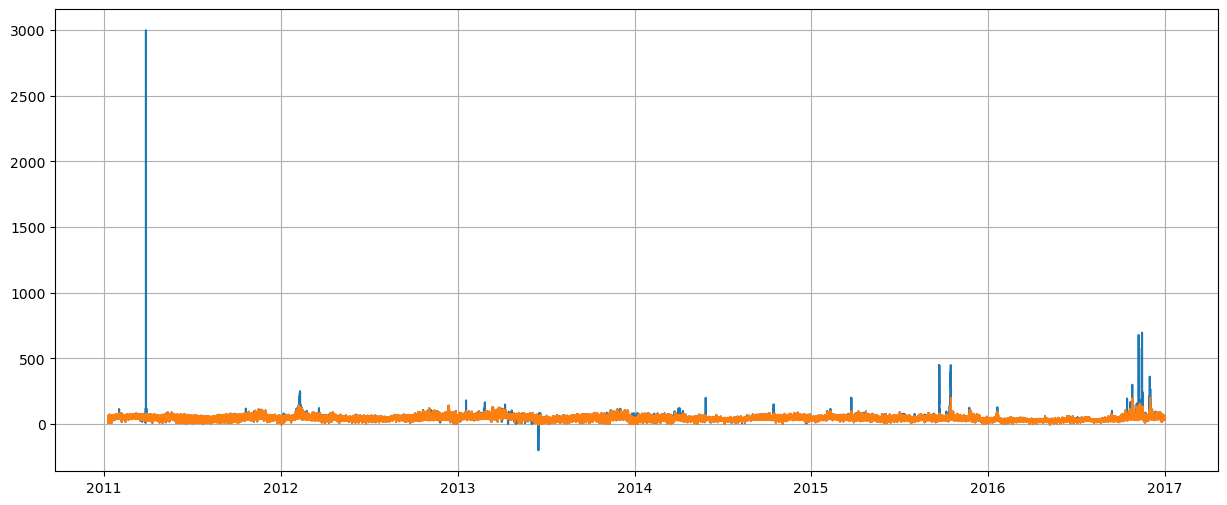

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [11]:
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, x in enumerate(names):
    df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [12]:
for hora in range(24):
    df['Price_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
        df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [13]:
for col in ['Price_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
    df[col+"_"+str(48)] = df[col].shift(48)
    df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)

In [14]:
for hora in range(24):
    df['Exogenous 1_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
        df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [15]:
for hora in range(24):
    df['Exogenous 2_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
        df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [16]:
for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)
for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)

In [17]:
list(df.columns)

['Date',
 'Price',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
 'Price_24',
 'Price_48',
 'Price_72',
 'Price_96',
 'Price_120',
 'Price_144',
 'Price_168',
 'diff_Price_24',
 'lower_quantile_diff_Price_24',
 'upper_quantile_diff_Price_24',
 'outlier',
 'Price_no_outliers',
 'Price_median',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'Price_hora_0',
 'Price_hora_1',
 'Price_hora_2',
 'Price_hora_3',
 'Price_hora_4',
 'Price_hora_5',
 'Price_hora_6',
 'Price_hora_7',
 'Price_hora_8',
 'Price_hora_9',
 'Price_hora_10',
 'Price_hora_11',
 'Price_hora_12',
 'Price_hora_13',
 'Price_hora_14',
 'Price_hora_15',
 'Price_hora_16',
 'Price_hora_17',
 'Price_hora_18',
 'Price_hora_19',
 'Price_hora_20',
 'Price_hora_21',
 'Price_hora_22',
 'Price_hora_23',
 'Price_hora_0_24',
 'Price_hora_0_48',
 'Price_hora_0_72',
 'Price_hora_0_168',
 'Price_hora_1_24',
 'Price_hora_1_48',
 'Price_hora_1_72',
 'Price_hora_1_168',
 'Price_hora_2_24',
 'Pric

In [18]:
columnas = ['Date',
 'Price',
 'Price_no_outliers',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
 'Price_24',
 'Price_48',
 'Price_72',
 'Price_168',
 'Price_hora_0',
 'Price_hora_1',
 'Price_hora_2',
 'Price_hora_3',
 'Price_hora_4',
 'Price_hora_5',
 'Price_hora_6',
 'Price_hora_7',
 'Price_hora_8',
 'Price_hora_9',
 'Price_hora_10',
 'Price_hora_11',
 'Price_hora_12',
 'Price_hora_13',
 'Price_hora_14',
 'Price_hora_15',
 'Price_hora_16',
 'Price_hora_17',
 'Price_hora_18',
 'Price_hora_19',
 'Price_hora_20',
 'Price_hora_21',
 'Price_hora_22',
 'Price_hora_23',
 'Price_hora_0_24',
 'Price_hora_0_48',
 'Price_hora_0_72',
 'Price_hora_0_168',
 'Price_hora_1_24',
 'Price_hora_1_48',
 'Price_hora_1_72',
 'Price_hora_1_168',
 'Price_hora_2_24',
 'Price_hora_2_48',
 'Price_hora_2_72',
 'Price_hora_2_168',
 'Price_hora_3_24',
 'Price_hora_3_48',
 'Price_hora_3_72',
 'Price_hora_3_168',
 'Price_hora_4_24',
 'Price_hora_4_48',
 'Price_hora_4_72',
 'Price_hora_4_168',
 'Price_hora_5_24',
 'Price_hora_5_48',
 'Price_hora_5_72',
 'Price_hora_5_168',
 'Price_hora_6_24',
 'Price_hora_6_48',
 'Price_hora_6_72',
 'Price_hora_6_168',
 'Price_hora_7_24',
 'Price_hora_7_48',
 'Price_hora_7_72',
 'Price_hora_7_168',
 'Price_hora_8_24',
 'Price_hora_8_48',
 'Price_hora_8_72',
 'Price_hora_8_168',
 'Price_hora_9_24',
 'Price_hora_9_48',
 'Price_hora_9_72',
 'Price_hora_9_168',
 'Price_hora_10_24',
 'Price_hora_10_48',
 'Price_hora_10_72',
 'Price_hora_10_168',
 'Price_hora_11_24',
 'Price_hora_11_48',
 'Price_hora_11_72',
 'Price_hora_11_168',
 'Price_hora_12_24',
 'Price_hora_12_48',
 'Price_hora_12_72',
 'Price_hora_12_168',
 'Price_hora_13_24',
 'Price_hora_13_48',
 'Price_hora_13_72',
 'Price_hora_13_168',
 'Price_hora_14_24',
 'Price_hora_14_48',
 'Price_hora_14_72',
 'Price_hora_14_168',
 'Price_hora_15_24',
 'Price_hora_15_48',
 'Price_hora_15_72',
 'Price_hora_15_168',
 'Price_hora_16_24',
 'Price_hora_16_48',
 'Price_hora_16_72',
 'Price_hora_16_168',
 'Price_hora_17_24',
 'Price_hora_17_48',
 'Price_hora_17_72',
 'Price_hora_17_168',
 'Price_hora_18_24',
 'Price_hora_18_48',
 'Price_hora_18_72',
 'Price_hora_18_168',
 'Price_hora_19_24',
 'Price_hora_19_48',
 'Price_hora_19_72',
 'Price_hora_19_168',
 'Price_hora_20_24',
 'Price_hora_20_48',
 'Price_hora_20_72',
 'Price_hora_20_168',
 'Price_hora_21_24',
 'Price_hora_21_48',
 'Price_hora_21_72',
 'Price_hora_21_168',
 'Price_hora_22_24',
 'Price_hora_22_48',
 'Price_hora_22_72',
 'Price_hora_22_168',
 'Price_hora_23_24',
 'Price_hora_23_48',
 'Price_hora_23_72',
 'Price_hora_23_168',
 'Exogenous 1_hora_0',
 'Exogenous 1_hora_1',
 'Exogenous 1_hora_2',
 'Exogenous 1_hora_3',
 'Exogenous 1_hora_4',
 'Exogenous 1_hora_5',
 'Exogenous 1_hora_6',
 'Exogenous 1_hora_7',
 'Exogenous 1_hora_8',
 'Exogenous 1_hora_9',
 'Exogenous 1_hora_10',
 'Exogenous 1_hora_11',
 'Exogenous 1_hora_12',
 'Exogenous 1_hora_13',
 'Exogenous 1_hora_14',
 'Exogenous 1_hora_15',
 'Exogenous 1_hora_16',
 'Exogenous 1_hora_17',
 'Exogenous 1_hora_18',
 'Exogenous 1_hora_19',
 'Exogenous 1_hora_20',
 'Exogenous 1_hora_21',
 'Exogenous 1_hora_22',
 'Exogenous 1_hora_23',
 'Exogenous 2_hora_0',
 'Exogenous 2_hora_1',
 'Exogenous 2_hora_2',
 'Exogenous 2_hora_3',
 'Exogenous 2_hora_4',
 'Exogenous 2_hora_5',
 'Exogenous 2_hora_6',
 'Exogenous 2_hora_7',
 'Exogenous 2_hora_8',
 'Exogenous 2_hora_9',
 'Exogenous 2_hora_10',
 'Exogenous 2_hora_11',
 'Exogenous 2_hora_12',
 'Exogenous 2_hora_13',
 'Exogenous 2_hora_14',
 'Exogenous 2_hora_15',
 'Exogenous 2_hora_16',
 'Exogenous 2_hora_17',
 'Exogenous 2_hora_18',
 'Exogenous 2_hora_19',
 'Exogenous 2_hora_20',
 'Exogenous 2_hora_21',
 'Exogenous 2_hora_22',
 'Exogenous 2_hora_23',
 'Exogenous 1_hora_0_24',
 'Exogenous 1_hora_0_168',
 'Exogenous 1_hora_1_24',
 'Exogenous 1_hora_1_168',
 'Exogenous 1_hora_2_24',
 'Exogenous 1_hora_2_168',
 'Exogenous 1_hora_3_24',
 'Exogenous 1_hora_3_168',
 'Exogenous 1_hora_4_24',
 'Exogenous 1_hora_4_168',
 'Exogenous 1_hora_5_24',
 'Exogenous 1_hora_5_168',
 'Exogenous 1_hora_6_24',
 'Exogenous 1_hora_6_168',
 'Exogenous 1_hora_7_24',
 'Exogenous 1_hora_7_168',
 'Exogenous 1_hora_8_24',
 'Exogenous 1_hora_8_168',
 'Exogenous 1_hora_9_24',
 'Exogenous 1_hora_9_168',
 'Exogenous 1_hora_10_24',
 'Exogenous 1_hora_10_168',
 'Exogenous 1_hora_11_24',
 'Exogenous 1_hora_11_168',
 'Exogenous 1_hora_12_24',
 'Exogenous 1_hora_12_168',
 'Exogenous 1_hora_13_24',
 'Exogenous 1_hora_13_168',
 'Exogenous 1_hora_14_24',
 'Exogenous 1_hora_14_168',
 'Exogenous 1_hora_15_24',
 'Exogenous 1_hora_15_168',
 'Exogenous 1_hora_16_24',
 'Exogenous 1_hora_16_168',
 'Exogenous 1_hora_17_24',
 'Exogenous 1_hora_17_168',
 'Exogenous 1_hora_18_24',
 'Exogenous 1_hora_18_168',
 'Exogenous 1_hora_19_24',
 'Exogenous 1_hora_19_168',
 'Exogenous 1_hora_20_24',
 'Exogenous 1_hora_20_168',
 'Exogenous 1_hora_21_24',
 'Exogenous 1_hora_21_168',
 'Exogenous 1_hora_22_24',
 'Exogenous 1_hora_22_168',
 'Exogenous 1_hora_23_24',
 'Exogenous 1_hora_23_168',
 'Exogenous 2_hora_0_24',
 'Exogenous 2_hora_0_168',
 'Exogenous 2_hora_1_24',
 'Exogenous 2_hora_1_168',
 'Exogenous 2_hora_2_24',
 'Exogenous 2_hora_2_168',
 'Exogenous 2_hora_3_24',
 'Exogenous 2_hora_3_168',
 'Exogenous 2_hora_4_24',
 'Exogenous 2_hora_4_168',
 'Exogenous 2_hora_5_24',
 'Exogenous 2_hora_5_168',
 'Exogenous 2_hora_6_24',
 'Exogenous 2_hora_6_168',
 'Exogenous 2_hora_7_24',
 'Exogenous 2_hora_7_168',
 'Exogenous 2_hora_8_24',
 'Exogenous 2_hora_8_168',
 'Exogenous 2_hora_9_24',
 'Exogenous 2_hora_9_168',
 'Exogenous 2_hora_10_24',
 'Exogenous 2_hora_10_168',
 'Exogenous 2_hora_11_24',
 'Exogenous 2_hora_11_168',
 'Exogenous 2_hora_12_24',
 'Exogenous 2_hora_12_168',
 'Exogenous 2_hora_13_24',
 'Exogenous 2_hora_13_168',
 'Exogenous 2_hora_14_24',
 'Exogenous 2_hora_14_168',
 'Exogenous 2_hora_15_24',
 'Exogenous 2_hora_15_168',
 'Exogenous 2_hora_16_24',
 'Exogenous 2_hora_16_168',
 'Exogenous 2_hora_17_24',
 'Exogenous 2_hora_17_168',
 'Exogenous 2_hora_18_24',
 'Exogenous 2_hora_18_168',
 'Exogenous 2_hora_19_24',
 'Exogenous 2_hora_19_168',
 'Exogenous 2_hora_20_24',
 'Exogenous 2_hora_20_168',
 'Exogenous 2_hora_21_24',
 'Exogenous 2_hora_21_168',
 'Exogenous 2_hora_22_24',
 'Exogenous 2_hora_22_168',
 'Exogenous 2_hora_23_24',
 'Exogenous 2_hora_23_168']

columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday']

In [19]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['Price_real'].append(row[col])
#                     if np.abs(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0]) > 5:
#                         scaler.scale_ =  np.abs((row[col] - scaler.mean_)/5)
                elif col == 'Price_no_outliers':
                    dict_new_df['scaler'].append(scaler)
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [20]:
dict_new_df = standard_movil(df[columnas])

100%|████████████████████████████████████████████████████████████████████████████| 52416/52416 [54:51<00:00, 15.92it/s]


In [21]:
df = df.drop(df.head(168).index)

In [22]:
with open('dict_new_df_be_epftoolbox_final_no_outliers.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [23]:
# df = df.drop(df.head(168).index)

In [7]:
# with open('dict_new_df_be_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [8]:
for k, v in dict_new_df.items():
    print(k, len(v))

Date 52248
Price 52248
Price_no_outliers 52248
Exogenous 1 52248
Exogenous 2 52248
Simple Date 52248
Hour 52248
Price_24 52248
Price_48 52248
Price_72 52248
Price_168 52248
Price_hora_0 52248
Price_hora_1 52248
Price_hora_2 52248
Price_hora_3 52248
Price_hora_4 52248
Price_hora_5 52248
Price_hora_6 52248
Price_hora_7 52248
Price_hora_8 52248
Price_hora_9 52248
Price_hora_10 52248
Price_hora_11 52248
Price_hora_12 52248
Price_hora_13 52248
Price_hora_14 52248
Price_hora_15 52248
Price_hora_16 52248
Price_hora_17 52248
Price_hora_18 52248
Price_hora_19 52248
Price_hora_20 52248
Price_hora_21 52248
Price_hora_22 52248
Price_hora_23 52248
Price_hora_0_24 52248
Price_hora_0_48 52248
Price_hora_0_72 52248
Price_hora_0_168 52248
Price_hora_1_24 52248
Price_hora_1_48 52248
Price_hora_1_72 52248
Price_hora_1_168 52248
Price_hora_2_24 52248
Price_hora_2_48 52248
Price_hora_2_72 52248
Price_hora_2_168 52248
Price_hora_3_24 52248
Price_hora_3_48 52248
Price_hora_3_72 52248
Price_hora_3_168 52248
P

In [9]:
df_nuevo = pd.DataFrame(dict_new_df)

In [10]:
for col in columnas_post:
    df_nuevo[col] = df[col].to_numpy()

NameError: name 'columnas_post' is not defined

In [11]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [12]:
df_scalers

,Date,scaler
0,2011-01-16 00:00:00,StandardScaler()
1,2011-01-16 01:00:00,StandardScaler()
2,2011-01-16 02:00:00,StandardScaler()
3,2011-01-16 03:00:00,StandardScaler()
4,2011-01-16 04:00:00,StandardScaler()
...,...,...
52243,2016-12-31 19:00:00,StandardScaler()
52244,2016-12-31 20:00:00,StandardScaler()
52245,2016-12-31 21:00:00,StandardScaler()
52246,2016-12-31 22:00:00,StandardScaler()


In [13]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [14]:
df = df_nuevo

In [15]:
df.index = df.Date

In [16]:
df = df.drop(['Date'], axis = 1)

In [17]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [18]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [19]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [20]:
forecast_dates = forecast.index

In [21]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [22]:
calibration_window = 2*364

In [23]:
model = LEAR(calibration_window=calibration_window)

In [24]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [25]:
df_original = pd.read_csv(r"Data\EPFToolbox\BE.csv")

In [26]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [27]:
df_original.index = df_original.Date

In [28]:
df_original = df_original.drop('Date', axis = 1)

In [29]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [30]:
df_original = df_original[df_original.index >= dt.datetime(2015, 1, 1)]

In [31]:
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [32]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,33.29,32.47,34.73,40.95,51.25,52.55,49.55,46.31,48.75,47.59
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,41.00,39.78,39.73,50.24,54.10,53.13,48.81,42.99,48.76,48.45
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,42.44,39.94,42.44,53.10,49.82,47.62,43.79,42.44,42.03,40.91
2015-01-04,36.26,32.28,27.63,27.03,27.04,27.19,27.13,27.06,27.63,34.54,...,37.00,36.87,40.00,53.10,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-05,36.56,34.94,32.19,28.05,28.04,34.26,44.28,50.38,53.79,52.03,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,35.30,38.33,41.04,34.62,29.69,28.35,30.99,42.08,45.27,46.56,...,51.27,51.82,65.19,69.99,72.89,72.15,52.07,44.00,56.41,63.25
2016-12-28,37.12,36.03,34.15,36.03,33.95,34.82,43.70,51.00,53.00,57.34,...,50.77,51.60,55.20,63.29,63.70,59.82,61.20,50.00,43.18,43.77
2016-12-29,42.28,39.30,36.83,34.11,34.99,37.64,41.05,49.30,53.30,53.93,...,49.60,51.63,54.43,63.95,64.35,56.72,48.50,45.66,46.94,44.08


In [33]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))


KeyboardInterrupt



In [51]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.459949,38.953051,37.105894,33.811144,31.13605,31.731463,31.167352,38.127862,37.628818,41.580966,...,40.52745,37.969916,38.80948,50.447296,52.618613,52.850703,49.086319,44.865408,46.690107,44.548435
2015-01-02,43.29121,38.172536,37.568381,33.589844,32.257261,33.254217,36.371669,41.84722,43.760839,46.957015,...,43.06858,40.800076,42.149134,50.70527,53.78643,53.261718,50.770773,46.580825,48.276338,45.467175
2015-01-03,41.382517,37.629588,35.24266,31.057306,28.971329,30.844829,32.765229,37.97516,41.188024,44.233594,...,39.705935,37.850907,38.814167,47.838467,51.77388,49.656564,45.705174,41.738586,44.075142,41.226264
2015-01-04,39.39769,34.381133,33.2422,29.288953,26.469738,28.474653,27.243149,30.388215,34.169356,36.770325,...,36.37445,34.944649,37.630801,47.058269,50.929872,49.382746,47.422624,44.801942,43.512303,40.712705
2015-01-05,38.916845,36.435381,34.123711,30.956416,29.681251,34.720446,40.829019,47.782777,48.717354,50.522556,...,46.994446,46.793042,48.796632,58.958249,58.059473,54.8827,52.385095,46.57075,49.124883,45.111267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,38.367688,33.260273,30.330484,26.581283,23.146645,26.308997,38.791017,50.430889,54.064103,57.527669,...,48.283918,48.522184,51.866554,61.608434,61.975724,60.861875,56.357317,47.553561,49.776356,48.284438
2016-12-28,43.602556,37.51336,36.124539,32.918734,30.249174,32.48623,43.064887,53.616478,57.68859,59.743636,...,50.277799,49.445926,56.731357,64.5353,66.808433,67.120445,58.625313,48.648885,53.114764,51.745074
2016-12-29,37.981404,34.660811,32.630706,30.906038,30.527255,33.461214,45.951989,57.32852,62.902527,62.537374,...,54.809504,55.143801,59.019872,67.9837,72.481827,69.257351,63.232333,53.416163,51.392033,47.727511


In [52]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_be_epftoolbox_final_2_anos_ventana_no_outliers.csv")

In [34]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [35]:
forecast_dates = forecast.index

In [36]:
calibration_window = 1*364

In [37]:
model = LEAR(calibration_window=calibration_window)

In [38]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 15.81%  |  MAE: 6.334
2015-01-02 - sMAPE: 12.71%  |  MAE: 4.916
2015-01-03 - sMAPE: 10.68%  |  MAE: 4.175
2015-01-04 - sMAPE: 9.92%  |  MAE: 3.820
2015-01-05 - sMAPE: 8.96%  |  MAE: 3.485
2015-01-06 - sMAPE: 8.49%  |  MAE: 3.386
2015-01-07 - sMAPE: 7.91%  |  MAE: 3.173
2015-01-08 - sMAPE: 7.77%  |  MAE: 3.121
2015-01-09 - sMAPE: 8.54%  |  MAE: 3.376
2015-01-10 - sMAPE: 9.25%  |  MAE: 3.583
2015-01-11 - sMAPE: 9.59%  |  MAE: 3.624
2015-01-12 - sMAPE: 9.27%  |  MAE: 3.482
2015-01-13 - sMAPE: 9.29%  |  MAE: 3.518
2015-01-14 - sMAPE: 8.92%  |  MAE: 3.381
2015-01-15 - sMAPE: 9.24%  |  MAE: 3.535
2015-01-16 - sMAPE: 9.13%  |  MAE: 3.498
2015-01-17 - sMAPE: 8.98%  |  MAE: 3.444
2015-01-18 - sMAPE: 8.88%  |  MAE: 3.410
2015-01-19 - sMAPE: 8.64%  |  MAE: 3.339
2015-01-20 - sMAPE: 8.42%  |  MAE: 3.278
2015-01-21 - sMAPE: 8.37%  |  MAE: 3.286
2015-01-22 - sMAPE: 8.31%  |  MAE: 3.303
2015-01-23 - sMAPE: 8.14%  |  MAE: 3.258
2015-01-24 - sMAPE: 8.11%  |  MAE: 3.255
2015-01-25 - 

2015-07-18 - sMAPE: 14.69%  |  MAE: 6.391
2015-07-19 - sMAPE: 14.71%  |  MAE: 6.394
2015-07-20 - sMAPE: 14.69%  |  MAE: 6.386
2015-07-21 - sMAPE: 14.66%  |  MAE: 6.374
2015-07-22 - sMAPE: 14.61%  |  MAE: 6.354
2015-07-23 - sMAPE: 14.58%  |  MAE: 6.341
2015-07-24 - sMAPE: 14.53%  |  MAE: 6.322
2015-07-25 - sMAPE: 14.68%  |  MAE: 6.360
2015-07-26 - sMAPE: 14.73%  |  MAE: 6.364
2015-07-27 - sMAPE: 14.77%  |  MAE: 6.370
2015-07-28 - sMAPE: 14.86%  |  MAE: 6.392
2015-07-29 - sMAPE: 14.88%  |  MAE: 6.391
2015-07-30 - sMAPE: 14.89%  |  MAE: 6.389
2015-07-31 - sMAPE: 14.87%  |  MAE: 6.381
2015-08-01 - sMAPE: 14.86%  |  MAE: 6.368
2015-08-02 - sMAPE: 14.91%  |  MAE: 6.379
2015-08-03 - sMAPE: 14.95%  |  MAE: 6.390
2015-08-04 - sMAPE: 14.97%  |  MAE: 6.397
2015-08-05 - sMAPE: 14.96%  |  MAE: 6.387
2015-08-06 - sMAPE: 14.93%  |  MAE: 6.376
2015-08-07 - sMAPE: 14.89%  |  MAE: 6.358
2015-08-08 - sMAPE: 14.90%  |  MAE: 6.352
2015-08-09 - sMAPE: 14.88%  |  MAE: 6.338
2015-08-10 - sMAPE: 14.88%  |  MAE

2016-01-30 - sMAPE: 15.42%  |  MAE: 7.093
2016-01-31 - sMAPE: 15.46%  |  MAE: 7.086
2016-02-01 - sMAPE: 15.47%  |  MAE: 7.080
2016-02-02 - sMAPE: 15.48%  |  MAE: 7.070
2016-02-03 - sMAPE: 15.46%  |  MAE: 7.058
2016-02-04 - sMAPE: 15.45%  |  MAE: 7.047
2016-02-05 - sMAPE: 15.44%  |  MAE: 7.037
2016-02-06 - sMAPE: 15.46%  |  MAE: 7.030
2016-02-07 - sMAPE: 15.48%  |  MAE: 7.021
2016-02-08 - sMAPE: 15.49%  |  MAE: 7.012
2016-02-09 - sMAPE: 15.47%  |  MAE: 6.999
2016-02-10 - sMAPE: 15.46%  |  MAE: 6.989
2016-02-11 - sMAPE: 15.44%  |  MAE: 6.977
2016-02-12 - sMAPE: 15.42%  |  MAE: 6.966
2016-02-13 - sMAPE: 15.41%  |  MAE: 6.955
2016-02-14 - sMAPE: 15.44%  |  MAE: 6.948
2016-02-15 - sMAPE: 15.42%  |  MAE: 6.936
2016-02-16 - sMAPE: 15.42%  |  MAE: 6.931
2016-02-17 - sMAPE: 15.42%  |  MAE: 6.926
2016-02-18 - sMAPE: 15.40%  |  MAE: 6.914
2016-02-19 - sMAPE: 15.39%  |  MAE: 6.907
2016-02-20 - sMAPE: 15.41%  |  MAE: 6.902
2016-02-21 - sMAPE: 15.44%  |  MAE: 6.893
2016-02-22 - sMAPE: 15.44%  |  MAE

2016-08-13 - sMAPE: 14.84%  |  MAE: 5.839
2016-08-14 - sMAPE: 14.84%  |  MAE: 5.834
2016-08-15 - sMAPE: 14.83%  |  MAE: 5.829
2016-08-16 - sMAPE: 14.81%  |  MAE: 5.821
2016-08-17 - sMAPE: 14.80%  |  MAE: 5.816
2016-08-18 - sMAPE: 14.79%  |  MAE: 5.810
2016-08-19 - sMAPE: 14.78%  |  MAE: 5.805
2016-08-20 - sMAPE: 14.77%  |  MAE: 5.799
2016-08-21 - sMAPE: 14.82%  |  MAE: 5.800
2016-08-22 - sMAPE: 14.81%  |  MAE: 5.795
2016-08-23 - sMAPE: 14.79%  |  MAE: 5.788
2016-08-24 - sMAPE: 14.78%  |  MAE: 5.782
2016-08-25 - sMAPE: 14.77%  |  MAE: 5.778
2016-08-26 - sMAPE: 14.75%  |  MAE: 5.773
2016-08-27 - sMAPE: 14.75%  |  MAE: 5.768
2016-08-28 - sMAPE: 14.74%  |  MAE: 5.762
2016-08-29 - sMAPE: 14.75%  |  MAE: 5.765
2016-08-30 - sMAPE: 14.76%  |  MAE: 5.765
2016-08-31 - sMAPE: 14.76%  |  MAE: 5.763
2016-09-01 - sMAPE: 14.74%  |  MAE: 5.758
2016-09-02 - sMAPE: 14.75%  |  MAE: 5.758
2016-09-03 - sMAPE: 14.75%  |  MAE: 5.755
2016-09-04 - sMAPE: 14.74%  |  MAE: 5.749
2016-09-05 - sMAPE: 14.75%  |  MAE

In [39]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,41.276644,38.028593,36.594946,32.731429,30.575417,31.928184,30.732268,38.978907,39.421357,42.795578,...,40.97399,39.227246,39.366396,52.474523,52.656173,52.65305,49.479171,44.386475,44.373826,42.512844
2015-01-02,41.785533,37.379586,37.545355,33.661714,33.200994,33.766248,37.274528,43.3423,42.800149,46.916738,...,43.14196,41.201302,42.571404,51.093159,53.430394,53.687023,50.841014,45.009586,45.762592,43.622813
2015-01-03,40.163751,37.541139,34.990945,31.689507,29.818815,31.372907,33.619157,39.928271,41.064095,44.512085,...,39.251176,37.47858,40.917742,47.374696,50.755646,50.374678,45.599515,40.568826,44.536415,42.990229
2015-01-04,39.066979,34.717295,33.040727,31.529886,30.75372,28.40269,27.387037,30.54369,33.352618,36.484,...,35.967313,34.406978,36.322826,46.315075,51.488036,49.625935,46.982503,41.055895,46.280951,41.572755
2015-01-05,38.882491,35.547981,34.315902,32.561114,32.849534,34.622261,40.537462,50.055078,49.998439,50.968222,...,46.792273,47.133064,49.000142,57.727647,56.250454,54.417153,50.187365,44.75844,47.54347,44.152134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,37.118518,33.430833,32.547863,28.803858,27.936825,31.505342,39.55767,53.82648,58.107041,56.472516,...,48.215996,50.097036,52.190675,63.182277,63.561164,62.733602,56.424572,46.709145,49.095204,46.977605
2016-12-28,42.746982,37.963807,36.923065,34.26348,33.406236,35.377751,44.479345,54.496768,60.433821,61.414187,...,50.983292,51.396765,58.079363,67.028377,66.475254,68.511551,60.96135,48.794262,51.152884,49.796251
2016-12-29,37.289961,35.13932,34.200508,31.935893,31.419217,34.344258,45.569931,57.341208,60.587773,60.329039,...,55.037435,56.160825,58.410313,68.444443,70.396281,71.601302,63.28358,52.979018,53.851024,49.563897


In [40]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_be_epftoolbox_final_1_ano_ventana_no_outliers.csv")

In [41]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [42]:
forecast_dates = forecast.index

In [43]:
calibration_window = 182

In [44]:
model = LEAR(calibration_window=calibration_window)

In [45]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 16.26%  |  MAE: 6.559
2015-01-02 - sMAPE: 13.03%  |  MAE: 5.126
2015-01-03 - sMAPE: 11.21%  |  MAE: 4.438
2015-01-04 - sMAPE: 10.84%  |  MAE: 4.206
2015-01-05 - sMAPE: 9.71%  |  MAE: 3.805
2015-01-06 - sMAPE: 9.02%  |  MAE: 3.588
2015-01-07 - sMAPE: 8.35%  |  MAE: 3.340
2015-01-08 - sMAPE: 8.09%  |  MAE: 3.236
2015-01-09 - sMAPE: 8.98%  |  MAE: 3.547
2015-01-10 - sMAPE: 9.64%  |  MAE: 3.729
2015-01-11 - sMAPE: 10.20%  |  MAE: 3.863
2015-01-12 - sMAPE: 9.88%  |  MAE: 3.726
2015-01-13 - sMAPE: 9.78%  |  MAE: 3.722
2015-01-14 - sMAPE: 9.47%  |  MAE: 3.598
2015-01-15 - sMAPE: 9.70%  |  MAE: 3.721
2015-01-16 - sMAPE: 9.70%  |  MAE: 3.732
2015-01-17 - sMAPE: 9.49%  |  MAE: 3.655
2015-01-18 - sMAPE: 9.28%  |  MAE: 3.580
2015-01-19 - sMAPE: 9.08%  |  MAE: 3.527
2015-01-20 - sMAPE: 8.96%  |  MAE: 3.514
2015-01-21 - sMAPE: 8.94%  |  MAE: 3.541
2015-01-22 - sMAPE: 8.94%  |  MAE: 3.585
2015-01-23 - sMAPE: 8.77%  |  MAE: 3.539
2015-01-24 - sMAPE: 8.82%  |  MAE: 3.570
2015-01-25 


KeyboardInterrupt



In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_be_epftoolbox_final_6_meses_ventana_no_outliers.csv")

In [38]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [39]:
forecast_dates = forecast.index

In [40]:
calibration_window = None

In [41]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 11.97%  |  MAE: 4.750
2015-01-02 - sMAPE: 10.69%  |  MAE: 4.074
2015-01-03 - sMAPE: 9.56%  |  MAE: 3.695
2015-01-04 - sMAPE: 8.85%  |  MAE: 3.380
2015-01-05 - sMAPE: 8.06%  |  MAE: 3.148
2015-01-06 - sMAPE: 7.62%  |  MAE: 3.042
2015-01-07 - sMAPE: 7.22%  |  MAE: 2.908
2015-01-08 - sMAPE: 7.13%  |  MAE: 2.871
2015-01-09 - sMAPE: 7.87%  |  MAE: 3.119
2015-01-10 - sMAPE: 8.77%  |  MAE: 3.395
2015-01-11 - sMAPE: 9.02%  |  MAE: 3.395
2015-01-12 - sMAPE: 8.69%  |  MAE: 3.257
2015-01-13 - sMAPE: 8.72%  |  MAE: 3.303
2015-01-14 - sMAPE: 8.49%  |  MAE: 3.213
2015-01-15 - sMAPE: 8.78%  |  MAE: 3.349
2015-01-16 - sMAPE: 8.69%  |  MAE: 3.313
2015-01-17 - sMAPE: 8.57%  |  MAE: 3.270
2015-01-18 - sMAPE: 8.63%  |  MAE: 3.299
2015-01-19 - sMAPE: 8.38%  |  MAE: 3.222
2015-01-20 - sMAPE: 8.08%  |  MAE: 3.118
2015-01-21 - sMAPE: 7.98%  |  MAE: 3.103
2015-01-22 - sMAPE: 7.85%  |  MAE: 3.085
2015-01-23 - sMAPE: 7.72%  |  MAE: 3.055
2015-01-24 - sMAPE: 7.66%  |  MAE: 3.041
2015-01-25 - s

2015-07-18 - sMAPE: 14.07%  |  MAE: 6.121
2015-07-19 - sMAPE: 14.09%  |  MAE: 6.122
2015-07-20 - sMAPE: 14.07%  |  MAE: 6.112
2015-07-21 - sMAPE: 14.03%  |  MAE: 6.100
2015-07-22 - sMAPE: 13.99%  |  MAE: 6.083
2015-07-23 - sMAPE: 13.95%  |  MAE: 6.070
2015-07-24 - sMAPE: 13.91%  |  MAE: 6.053
2015-07-25 - sMAPE: 14.05%  |  MAE: 6.088
2015-07-26 - sMAPE: 14.09%  |  MAE: 6.086
2015-07-27 - sMAPE: 14.13%  |  MAE: 6.096
2015-07-28 - sMAPE: 14.21%  |  MAE: 6.114
2015-07-29 - sMAPE: 14.22%  |  MAE: 6.109
2015-07-30 - sMAPE: 14.24%  |  MAE: 6.111
2015-07-31 - sMAPE: 14.22%  |  MAE: 6.102
2015-08-01 - sMAPE: 14.20%  |  MAE: 6.089
2015-08-02 - sMAPE: 14.26%  |  MAE: 6.101
2015-08-03 - sMAPE: 14.28%  |  MAE: 6.105
2015-08-04 - sMAPE: 14.30%  |  MAE: 6.110
2015-08-05 - sMAPE: 14.28%  |  MAE: 6.101
2015-08-06 - sMAPE: 14.25%  |  MAE: 6.088
2015-08-07 - sMAPE: 14.22%  |  MAE: 6.071
2015-08-08 - sMAPE: 14.23%  |  MAE: 6.067
2015-08-09 - sMAPE: 14.19%  |  MAE: 6.049
2015-08-10 - sMAPE: 14.19%  |  MAE

2016-01-30 - sMAPE: 14.75%  |  MAE: 6.823
2016-01-31 - sMAPE: 14.77%  |  MAE: 6.814
2016-02-01 - sMAPE: 14.78%  |  MAE: 6.808
2016-02-02 - sMAPE: 14.79%  |  MAE: 6.798
2016-02-03 - sMAPE: 14.78%  |  MAE: 6.786
2016-02-04 - sMAPE: 14.76%  |  MAE: 6.775
2016-02-05 - sMAPE: 14.76%  |  MAE: 6.766
2016-02-06 - sMAPE: 14.77%  |  MAE: 6.760
2016-02-07 - sMAPE: 14.78%  |  MAE: 6.749
2016-02-08 - sMAPE: 14.77%  |  MAE: 6.738
2016-02-09 - sMAPE: 14.76%  |  MAE: 6.726
2016-02-10 - sMAPE: 14.74%  |  MAE: 6.715
2016-02-11 - sMAPE: 14.72%  |  MAE: 6.703
2016-02-12 - sMAPE: 14.70%  |  MAE: 6.692
2016-02-13 - sMAPE: 14.69%  |  MAE: 6.681
2016-02-14 - sMAPE: 14.71%  |  MAE: 6.673
2016-02-15 - sMAPE: 14.69%  |  MAE: 6.661
2016-02-16 - sMAPE: 14.69%  |  MAE: 6.656
2016-02-17 - sMAPE: 14.69%  |  MAE: 6.651
2016-02-18 - sMAPE: 14.67%  |  MAE: 6.640
2016-02-19 - sMAPE: 14.67%  |  MAE: 6.634
2016-02-20 - sMAPE: 14.68%  |  MAE: 6.629
2016-02-21 - sMAPE: 14.69%  |  MAE: 6.618
2016-02-22 - sMAPE: 14.68%  |  MAE

In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_be_epftoolbox_final_sin_ventana_no_outliers.csv")